# Causal Inference for The Brave and True

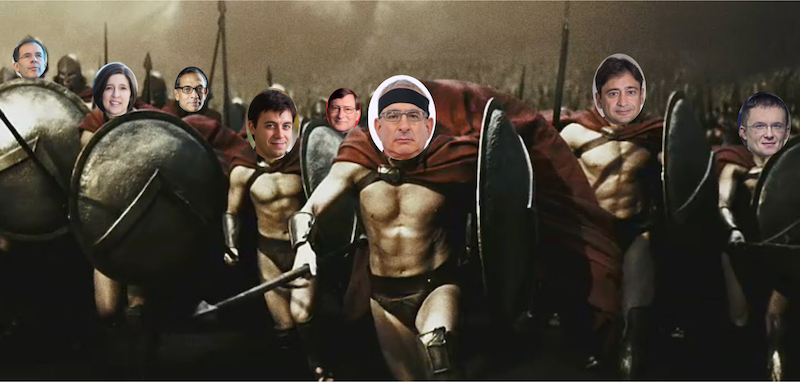

# 19 Evaluating Causal Models

Causal Inference for The Brave and True ([원문](https://github.com/CausalInferenceLab/Causal-Inference-with-Python), [가짜연구소 번역](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/tree/main/causal-inference-for-the-brave-and-true))  
19장 Evaluating Causal Models ([원문](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/blob/main/causal-inference-for-the-brave-and-true/19-Evaluating%20Causal%20Models.ipynb), [가짜연구소 번역](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/blob/main/causal-inference-for-the-brave-and-true/19-Evaluating%20Causal%20Models.ipynb)) 발제 자료


Bowon Kwon  
2024년 4월 12일 생성    
2024년 4월 14일 발제

## 개요

* **머신러닝 모델**
  - training set - test set 나누어 간단히, 직관적으로 성능 확인 가능
  - **'훈련-테스트 분할 패러다임'**은 머신러닝이 성취한 큰 성공의 비결
* **인과추론 모델**
  - (실제로 관측되거나 수집된 데이터가 아니라, 인위적으로 생성한) **'합성 데이터(synthetic data)'** 사용하여 방법론의 타당성 확인하는 것이 대부분
  - 일어나지 않은 **반사실(counterfactuals)**에 대한 정보가 필요하나, 실제 세계에서는 데이터가 없음
  - 처치가 없을 때의 결과, 처치하였을 때의 결과 둘 중 하나이기 때문
  - 인과추론 모델을 평가하는 방법론에 관하여 다룬 자료를 거의 볼 수 없는 것도 그 때문
  - 이론이 얼마나 충실한지, 얼마나 꼼꼼하게 모델을 구축(training)하였는지 보이는 정도가 최선
  - 아래 그림에서 각 개체에 처치 전후의 기울기로 표시되는 반응성(responsiveness)이 있는 것처럼 보이지만 사실은 측정 불가

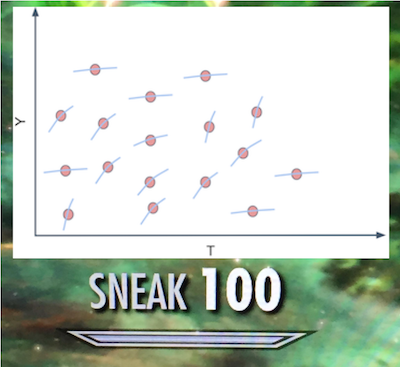

* **19장의 전략**
  * 인과추론에서도 훈련-테스트 패러다임과 유사한 평가 시도할 수
  * **개체 민감도(sensitivity, 탄력성)**를 측정할 수는 없어도 **그룹의 민감도를 집계(aggregate)**해서 추정하는 것
    * **민감도(Sensitivity):** 종속변수 변화량 / 독립변수 변화량    

    $$
\text{Sensitivity} = \frac{\Delta Y}{\Delta X}
$$
    * **탄력성(Elasticity):** 비율(백분율) 변화 측정 cf. 경제학   

$$
\text{Elasticity} = \frac{\% \Delta Y}{\% \Delta X} = \frac{\frac{\Delta Y}{Y}}{\frac{\Delta X}{X}}
$$

  * **비무작위(non-random) 데이터** 사용하여 인과 추론하고, **무작위(random) 데이터**를 사용하여 모델 평가
  * 실제 세계에서 무작위 데이터를 수집하려면 비용이 많이 들기 때문에(예컨대, 가격을 무작위로 책정하면 효과가 별로 없거나 큰 손해를 볼 것), 무작위 데이터가 있다면 평가 목적으로 보관해 두는 경향이 있음

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Coding/SundayAI/Causal Inference/Causal_Inference_In_Python/causal-inference-for-the-brave-and-true

/content/drive/MyDrive/Coding/SundayAI/Causal Inference/Causal_Inference_In_Python/causal-inference-for-the-brave-and-true


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns                 # 통계적 그래픽을 생성하는 matplotlib 기반 시각화 라이브러리 https://seaborn.pydata.org/; https://wikidocs.net/86290
from toolz import curry               # https://toolz.readthedocs.io/en/latest/curry.html
                                      # 커링(currying): 여러 개 인자 받는 함수를 하나의 인자만 받는 함수들의 연쇄로 변환하는 과정(코드 가독성, 재사용성 증대) https://wiki.haskell.org/Currying
                                      # Haskell Curry https://en.wikipedia.org/wiki/Haskell_Curry

import statsmodels.formula.api as smf # R 스타일로(ex. 'response ~ terms') 모델 공식 사용할 수 있게 사용자 친화적으로 만든 wrapper
import statsmodels.api as sm          # 더 전통적인 Python 방식(ex. 독립변수, 종속변수 이미 수치 데이터 배열로 준비되어 있어야) 사용하여 데이터를 더 세밀하게 제어할 수 있음
                                      # https://www.statsmodels.org/stable/api.html 참고
from sklearn.ensemble import GradientBoostingRegressor # scikit-learn 라이브러리에서 Gradient Boosting Regressor 임포트
                                                       # 회귀 문제에 사용되는 머신러닝 알고리듬, 여러 개의 결정 트리 조합하여 더 좋은 예측 성능 달성하는 앙상블 학습

import warnings                       # 경고 메시지 제어 위한 라이브러리
warnings.filterwarnings("ignore")     # 경고 메시지 무시하도록 설정(가독성 향상)

In [ ]:
prices = pd.read_csv("./data/ice_cream_sales.csv")         # 비무작위 데이터 로드
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # 무작위 데이터 로드
print(prices.shape)
print(prices_rnd.shape)
prices.head(10)

(10000, 5)
(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227
5,26.1,6,0.5,6.6,193
6,25.0,6,0.3,4.9,191
7,18.5,5,0.5,3.9,189
8,30.1,3,1.0,6.5,208
9,19.8,5,0.3,5.4,167


* 일평균기온(temp), 요일(weekday), 아이스크림 만드는 데 들어간 비용(cost, 품질의 proxy) --> 여기까지가 특성 공간(feature space) X,
* (+) 가격(price), 판매량(sales) 데이터 바탕으로 민감도(가격 탄력성) 예측하고, 언제 가격 올릴지 판단

### **첫 번째 모델(M1)은 상호작용이 있는 선형회귀**

  $$
sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i
$$    

</br>

  **민감도(sensitivity):**
$$
\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i
$$  

In [ ]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit() # 이렇게 써도 상호작용항뿐 아니라 각 변수의 독립적 효과도 함께 모델에 포함됨

print(m1.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     2470.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        10:34:22   Log-Likelihood:                -35604.
No. Observations:               10000   AIC:                         7.124e+04
Df Residuals:                    9982   BIC:                         7.137e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               200.11

* **(Adjusted) R-squared (결정계수) = 0.808**, 즉, 모델의 설명력이 80.8%로 매우 높음
  * R²값은 모델에 변수가 추가될 때마다 증가하는 경향
  * 조정된 R²(n은 표본 수, k는 독립변수의 수)
  $$
\text{Adjusted } R^2 = 1 - (1-R^2)\frac{(n-1)}{(n-k-1)}
$$
  * 그런데 위 모델에서는 조정된 R²가 같은 값(표본 크기가 10,000으로 크고, 독립 변수의 수가 17로 표본 크기에 비해 상대적으로 작아서)
* **모델 전체 p 값["Prob(F-statistic)"]**이 0.00으로 모델의 유의성이 매우 높고, 귀무가설 기각
* **Omnibus Test, Jarque-Bera Test**는 잔차의 왜도와 첨도에 기반한 **정규성 검정**(귀무가설 기각하므로 정규분포 따르지 않음)
* **Durbin-Watson Test (자기 상관 검정)**
  * 잔차들 사이의 독립성, 특히 시계열 데이터에서 자주 발생하는 **자기 상관(autocorrelation, 한 시점의 값이 이전 시점의 값과 어느 정도 상관 관계를 가지는 현상)** 평가
  * 2에 가까우면 자기 상관 없고, 0에 가까우면 양의 자기 상관, 4에 가까우면 음의 자기 상관
  * 1.966은 자기 상관이 없다는 좋은 신호
* **Condition Number (조건 수)**
  * 독립변수 간 다중공선성 평가
  * 조건 수 1,000 이상이면 다중공선성 문제될 수 있음을 의미
  * 7,560은 **강력한 다중공선성** 시사
  * 일부 변수를 모델에서 제거하거나 주성분 분석(PCA) 같은 차원 축소 기법 고려할 필요

### **두 번째 모델(M2)은 완전히 비모수적(nonparametric)인 머신러닝 기반 예측 모델**

  $$
sales_i = G(X_i, price_i) + e_i
$$

In [ ]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)                 # 난수 생성기에 특정한 시작점 제공하여 실험의 재현성 보장(코드 실행할 때마다 동일한 난수 생성하여 일관된 결과 유지), 꼭 1일 필요는 없고 임의의 정수 사용 가능
m2 = GradientBoostingRegressor()  # 아래에 상술
m2.fit(prices[X], prices[y]);     # 세미콜론은 큰 의미 없고 출력 숨기는 용도

* **GradientBoostingRegressor**
  * **그래디언트 부스팅(Gradient Boosting):** 앙상블 학습의 한 형태로, 여러 개의 약한 예측 모델(보통 결정 트리)을 조합하여 편향과 분산이 적은 강력한 예측 모델을 만드는 방법
  * **주요 특징**
    * **부스팅:** 여러 개의 약한 학습기(weak learner, 대표적으로 결정 트리)를 순차적으로 학습, 각 학습기는 이전 학습기가 만든 잔차 오류에 대한 학습 진행하고(즉, 이전 학습기가 잘못 분류한 샘플에 더 큰 가중치 부여), 이 과정 통해 모델 성능이 점진적으로 개선
    * **손실 함수 최적화:** 손실 함수의 그래디언트(기울기) 사용하여 모델 업데이트, 복잡한 비선형 문제에 효과적
    * **과적합 방지:** 학습률(learning rate) 낮게 설정하거나, 최대 깊이(max depth) 제한하는 방법 등 사용
  * **학습 과정**
    * **첫 번째 학습기 훈련:** 데이터에 기반하여 첫 번째 약한 학습기(결정 트리) 훈련, 이 트리는 데이터의 패턴을 간단하게 캡처
    * **오차 계산:** 첫 번째 학습기가 예측한 결과와 실제 값 사이의 오차(잔차) 계산
    * **오차 수정을 위한 학습:** 계산된 오차를 새로운 학습기가 학습 대상으로 삼아, 이 오차를 정확하게 예측하도록 다음 학습기 훈련
    * **학습기 추가 및 갱신:** 이 과정을 여러 번 반복하면서 각 학습기는 이전 학습기의 잔차를 줄이는 데 집중, 각 단계에서 학습기의 예측 결과가 이전 결과에 더해지므로 모델이 점점 더 정확해짐

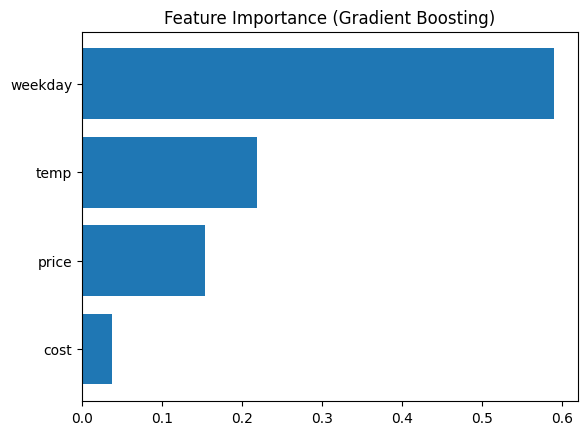

In [ ]:
feature_importance = m2.feature_importances_                  # 모델의 특성 중요도 계산
sorted_idx = np.argsort(feature_importance)                   # 중요도 값에 따라 특성들의 인덱스 정렬
pos = np.arange(sorted_idx.shape[0]) + .5                     # 그래프 위치
plt.barh(pos, feature_importance[sorted_idx], align='center') # 수평 막대 그래프
plt.yticks(pos, np.array(X)[sorted_idx])                      # Y축에 특성 이름 표시
plt.title('Feature Importance (Gradient Boosting)')           # 그래프 제목
plt.show()

* **특성 중요도(Feature Importance) 그래프**
  * 각각의 입력 변수가 모델 예측에 얼마나 영향을 미치는지를 상대적으로 보여줌
  * **요일**이 판매량 예측의 가장 큰 변수, 그다음이 온도, 가격
  * 비용은 낮은 중요도

In [ ]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


* **모델의 일반화 능력** 평가하기 위해 훈련 데이터와 별개로 준비된 테스트 데이터에 대한 R²점수(결정계수) 비교
  * **훈련 데이터의 R² 점수: 0.925**로, 모델이 훈련 데이터를 잘 설명함을 보여줌
  * **테스트 데이터의 R² 점수: 0.771**로, 훈련 데이터 점수보다는 낮지만 여전히 양호한 수준, 모델이 새로운 데이터에 대해서도 어느 정도 예측력 유지함을 나타냄
  * **성능 차이:** 테스트 데이터 점수가 훈련 데이터 점수보다 낮은 것은 일반적인 현상, 모델이 처음 보는 데이터에 대해 더 보수적인 예측을 할 가능성이 있기 때문
  * **컨셉트 드리프트(Concept Drift):** 훈련 데이터와 테스트 데이터 사이에 분포의 변화가 있을 때 발생, 예컨대 가격이 무작위화되지 않은 데이터로 훈련했지만, 테스트 데이터는 가격이 무작위화되어 있어 성능 차이가 나타날 수 있음

* 민감도(sensitivity) 추정
  * 함수의 미분을 다음과 같은 차분 근사로 대체

  $$
\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}
$$

  * **y(t)**는 예측하고자 하는 목표 변수(판매량), **t**는 민감도를 계산하고자 하는 변수(가격), **h**는 매우 작은 변화량

* 이제, 비무작위 데이터로 훈련시킨 모델을 가지고 무작위 데이터에 대한 예측 수행
  * **M1(선형회귀), M2(머신러닝)**의 민감도 예측을 prices_rnd_pred라는 단일 데이터프레임에 추가
  * **랜덤 모델(random model)**도 추가
    * 무의미하게 무작위 숫자 출력하지만 평가 기준으로 기능
    * 랜덤 모델이 좋은 성능 보인다면 평가 방법 재고 필요성 있음을 의미

In [ ]:
def predict_sensitivity(model, price_df, h=0.01):                     # 가격에 대한 판매량 민감도 예측하는 함수 정의
                                                                      # model: 모델, price_df: 가격 정보 포함하는 데이터프레임, h: 가격의 작은 변화량, 기본값은 0.01
    return (model.predict(price_df.assign(price=price_df["price"]+h)) # 주어진 가격에서 h만큼 증가시킨 새로운 데이터프레임으로 모델 예측 실행하고
            - model.predict(price_df)) / h                            # 원래 가격의 모델 예측값 뺀 다음, h로 나누어 민감도 계산

np.random.seed(123)                                             # 결과 재현성을 위한 난수 생성기의 시드 설정(모델 세 개라서 123?)
prices_rnd_pred = prices_rnd.assign(**{                         # 랜덤화된 데이터셋에 새로운 열 추가하여 민감도와 예측 결과 저장
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd),  # sensitivity model, m1 모델의 무작위 데이터 대한 (가격 변화량 대한 판매량 변화량) 민감도 계산
    "pred_m_pred": m2.predict(prices_rnd[X]),                   # predictive model, m2 모델의 무작위 데이터 대한 판매량 예측값(실제 판매 데이터와 비교 가능),
                                                                # predict 메서드는 fit 메서드 써서 학습한 모델로 새 데이터 대한 예측값 반환
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), # random model, 0과 1 사이 균일분포에서 데이터프레임 행 수만큼 난수 생성
                                                                  # (실제 모델이 단순 추측보다 유의미하게 더 나은지 확인)
})

prices_rnd_pred.head(10)                                        # 수정된 데이터 프레임 출력

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469
5,30.3,7,0.5,9,191,-15.226640,197.071032,0.423106
6,20.4,1,1.0,7,222,-12.179362,220.570764,0.980764
7,21.6,6,1.0,8,188,0.559057,185.291361,0.684830
8,24.8,6,0.5,8,192,0.156394,190.571127,0.480932
9,22.7,3,0.5,6,189,1.054695,185.056166,0.392118


## Sensitivity by Model Band

* **민감도 모델(sensitivity model)**은 특정 처치(예: 할인, 마케팅 캠페인)에 대한 고객의 반응을 이해하고자 할 때 필요
  * 예를 들어, 어떤 날에 사람들이 아이스크림에 더 많은 돈을 지불할 용의가 있는지, 가격 민감도가 낮은지 모델이 파악할 수 있어야
* 민감도 모델의 유효성을 평가하는 방법으로, **예측된 민감도 순서대로 고객을 정렬하는 방법** 생각할 수
  * 그리하여 예측된 민감도가 실제 민감도와 일치하는지 보면 될 것이나 개체 수준에서 평가가 불가능하다는 문제
* 처치가 무작위로 할당된다면, 예컨대, 할인받은 그룹과 받지 않은 그룹 간 판매량 차이 비교하여 할인행사의 **'평균적' 영향**을 평가할 수 있음   
  * 아래 이진(binary) 처치 사례에서 같은 크기의 세 그룹으로 나누어 각 그룹의 ATE 추정할 수 있음
  * $E[Y|T=1] - E[Y|T=0]$

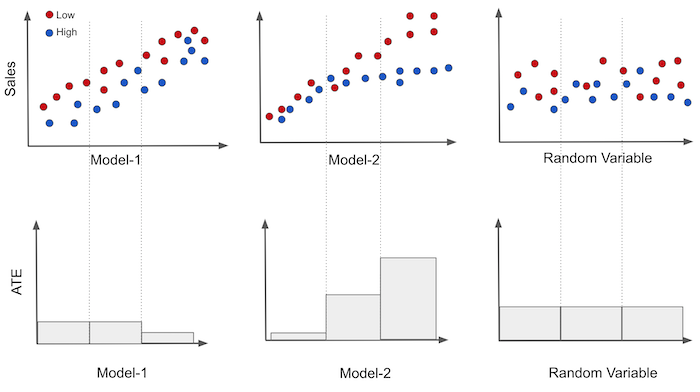

* **M1**은 판매량 예측에서는 어느 정도 성공적이지만, 모든 그룹이 비슷한 처치 효과(마지막 세그먼트만 다른 민감도)
* **M2**에서 생성된 각 그룹은 서로 다른 민감도 보여주는바, 개인화에 유용하다는 신호, 민감도가 정돈되어 있고 밴드 간 차이가 커서 M1보다 나은 모델
* **랜덤 모델**은 모든 그룹에서 동일한 민감도 나타냄, 유용하지 않은 것처럼 보일 수 있지만 예상된 결과로, 그룹 내 민감도는 전체 데이터셋의 평균 처치 효과(ATE)와 대략적으로 일치해야

* 연속적인 사례로 일반화하기 위해, 단순 선형회귀 모델로 민감도 추정
  * 선형회귀 모델&nbsp;&nbsp;&nbsp;$y_i = \beta_0 + \beta_1t_i + e_i$

  * 기울기 계수&nbsp;&nbsp;&nbsp;$\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}$

    * $\bar{t}$는 처치(독립변수, "가격")의 표본평균
    * $\bar{y}$는 결과(종속변수, "판매량")의 표본평균
    * 공분산&nbsp;&nbsp;&nbsp;$\text{Cov}(t, y) = \sum_{i=1}^n (t_i - \bar{t})(y_i - \bar{y})$
    * 독립변수의 분산&nbsp;&nbsp;&nbsp;$\text{Var}(t) = \sum_{i=1}^n (t_i - \bar{t})^2$
    * $\beta_1 = \frac{\text{Cov}(t, y)}{\text{Var}(t)}$


In [ ]:
@curry                                                                          # 커링 데코레이터로 인자를 미리 고정시키고, 나중에 인자 제공받아 함수 실행할 수 있게 함
def sensitivity(data, y, t):                                                    # 단순 선형회귀 기울기 계수 계산하여 민감도 반환(변화율을 민감도로 해석)
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) / # data[t]: 처치변수("price"), data[y]: 결과변수("salses")
                np.sum((data[t] - data[t].mean())**2))

In [ ]:
def sensitivity_by_band(df, pred, y, t, bands=10):                              # 데이터프레임 분할하고 각 분할의 민감도 계산
    return (df                                                                  # 메서드 체이닝
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)})              # df[pred] 기반으로 데이터를 분위수(quantile=10) 기반으로 분할
            .groupby(f"{pred}_band")                                            # 생성된 분할 따라 데이터 그룹화
            .apply(sensitivity(y=y, t=t)))                                      # 각 그룹 민감도 계산
                                                                                # 아래에서 보면, df는 prices_rnd_pred,
                                                                                  # pred는 m=["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"],
                                                                                  # y는 "sales", t는 "price"

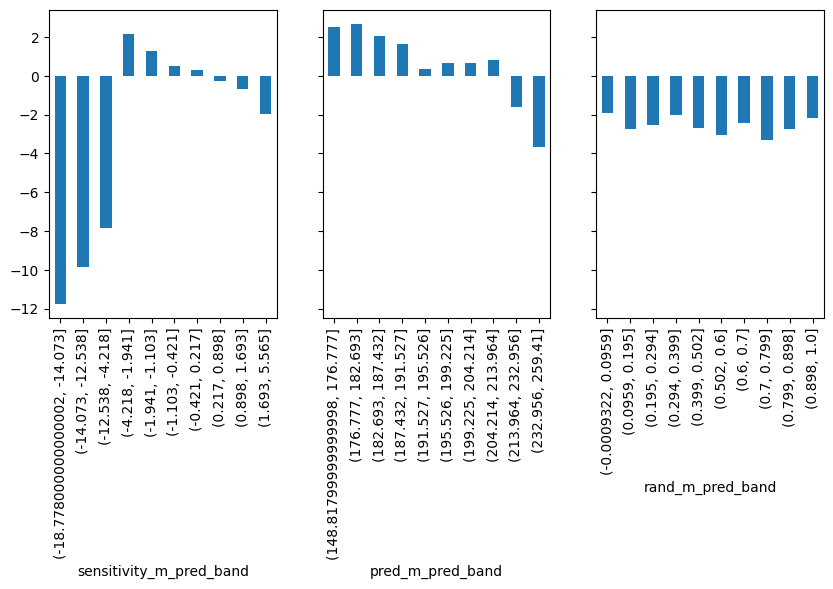

In [ ]:
# 분할별 민감도 그래프
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))                     # 너비 10인치, 높이 4인치 그래프 1행에 3개의 서브플롯을 만들고, 서브플롯이 Y축 공유하도록 설정
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):    # zip은 m(모델 이름), axs(서브플롯)를 튜플로 묶어서 병렬로 반복 가능하게 해줌
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

In [ ]:
results = {}
for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    result = sensitivity_by_band(prices_rnd_pred, m, "sales", "price")
    results[m] = result
    print(f"Results for {m}:")
    print(result)

Results for sensitivity_m_pred:
sensitivity_m_pred_band
(-18.778000000000002, -14.073]   -11.749212
(-14.073, -12.538]                -9.848638
(-12.538, -4.218]                 -7.872637
(-4.218, -1.941]                   2.159206
(-1.941, -1.103]                   1.293704
(-1.103, -0.421]                   0.499454
(-0.421, 0.217]                    0.298661
(0.217, 0.898]                    -0.289010
(0.898, 1.693]                    -0.666963
(1.693, 5.565]                    -1.958290
dtype: float64
Results for pred_m_pred:
pred_m_pred_band
(148.81799999999998, 176.777]    2.491128
(176.777, 182.693]               2.683296
(182.693, 187.432]               2.025007
(187.432, 191.527]               1.613456
(191.527, 195.526]               0.357217
(195.526, 199.225]               0.668942
(199.225, 204.214]               0.673691
(204.214, 213.964]               0.793278
(213.964, 232.956]              -1.627958
(232.956, 259.41]               -3.652271
dtype: float64
Results for 

* **랜덤 모델**은 각 분할에서 예상된 민감도 비슷하여 개인화에 도움되지 않음

* **M2**는 민감도가 높은 그룹과 낮은 그룹을 순서대로 성공적으로 나누어 유용

* **M1**은 약간 이상해 보이는데
  * 민감도가 매우 낮은 **극단적 그룹**(가격을 올리면 매출이 아주 많이 감소)을 식별하고 있음, 이렇게 가격 민감도가 높은 날을 파악하면 그런 날 가격을 올리지 않도록 주의할 수 있음
  * 가격이 덜 민감한 지역에서는 높은 민감도와 낮은 민감도 그룹을 성공적으로 나누고 있으나 M2와 비교할 때 그리 좋아 보이지 않음

* 어느 쪽이 낫다고 쉽게 답할 수 없어 더 정교한 방법이 필요


## Cumulative Sensitivity Curve

* 이제 앞에서 본 이진 처치 사례를 민감도가 높은 순서대로 정렬
  * M1, 랜덤 모델은 이미 정렬되어 있으므로 M2만 정렬
* 정렬된 그룹 갖고 나면 **'누적 민감도 곡선'** 구성할 수 있음
  * 첫 번째 구간은 가장 민감한 그룹으로부터의 ATE
  * 다음은 첫 번째, 두 번째 그룹까지의 민감도
  * 모든 모델에서 마지막에는 전체 데이터셋의 ATE로 수렴

(위에서 봤던 이진 처치 사례)

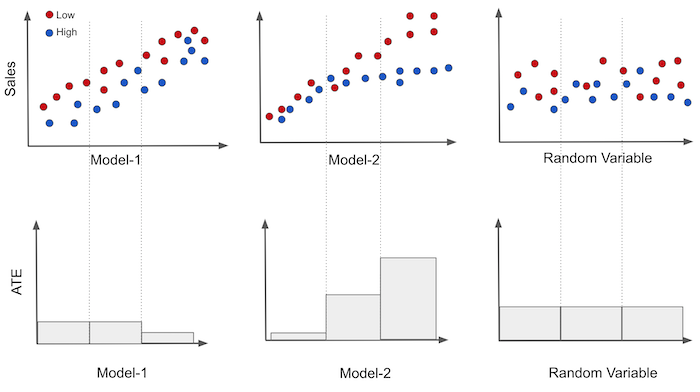

(새 그래프)

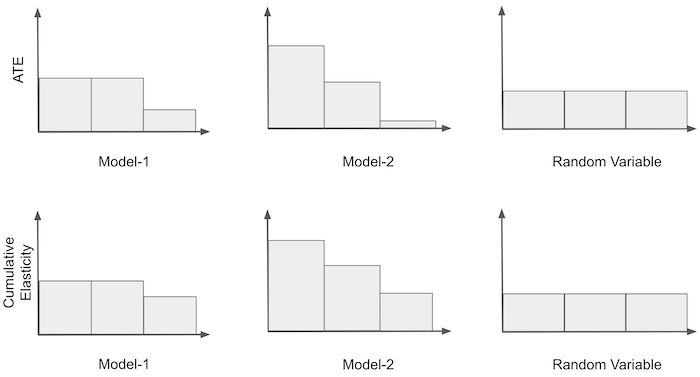

* 기울기(계수) = 민감도
$$
\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}
$$

* k 단위까지 추정된 **누적 민감도**

$$
\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}
$$

* 누적 민감도 곡선을 구하기 위해 데이터 함수에서 위 함수를 반복적으로 실행하는 아래와 같은 시퀀스 구성

$$
(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)
$$

  * 이것은 모델 평가 측면에서 매우 흥미로운 시퀀스인데, 모델이 얼마나 민감도를 잘 정렬하는지에 대한 선호도를 만들 수 있기 때문

  1. 어떤 모델이든, 상위 *k* 단위에서 관찰된 민감도가 상위 *k+a* 단위(하위 단위)에서 관찰된 민감도보다 높아야

  $\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$

  2. 상위 단위 민감도가 하위 단위 민감도보다 높으면서 그 차이가 클수록 좋은 모델, 즉 아래 식이 커야

  $\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

In [ ]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):   # 누적 민감도 계산할 때 시작 부분에서는 샘플 사이즈가 작아 초기 추정치가 불안정할 수(많은 잡음 있을 수) 있어서 min_periods 설정
    size = dataset.shape[0]                                                               # 데이터셋의 전체 행 수 가져오기
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)  # 'prediction' 열에 따라 데이터셋 내림차순 정렬, 기존 인덱스 버리고 0부터 시작하는 새 인덱스 생성
    n_rows = list(range(min_periods, size, size // steps)) + [size]                       # Ks(구간 또는 그룹 수)를 정의할 행 번호 시퀀스 생성
                                                                                          # 시작점 min_periods부터 끝점 size까지 size // steps (몫)의 간격으로 숫자 생성하고 리스트로 반환
                                                                                          # 시퀀스 마지막에 '[size]' 추가하여 전체 데이터셋 크기(데이터셋의 전체 행 수)를 리스트 마지막 요소로 포함
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])        # 누적 민감도 계산, 처음에는 최상위 min_periods 단위 대해 계산
                                                                                          # 그다음은 (min_periods + steps*1), (min_periods + steps*2) 등으로 계산

* 각 모델에서 첫 번째 그룹은 샘플 사이즈가 작아서 곡선 시작 부분에 민감도 노이즈가 심할 수 있음
  * (해결책) min_periods 설정하여 샘플 사이즈가 이미 충분히 큰 첫 번째 그룹을 전달
* 아래 그래프는 min_periods를 기본값 30이 아니라 100으로 설정
  * (효과) 더 안정적 초기 추정치 제공할 수 있지만 데이터셋이 작으면 초기 구간에 대한 추정치 얻지 못할 수도
  * 우리 데이터셋에서는 추정치 얻지 못하는 문제는 없음

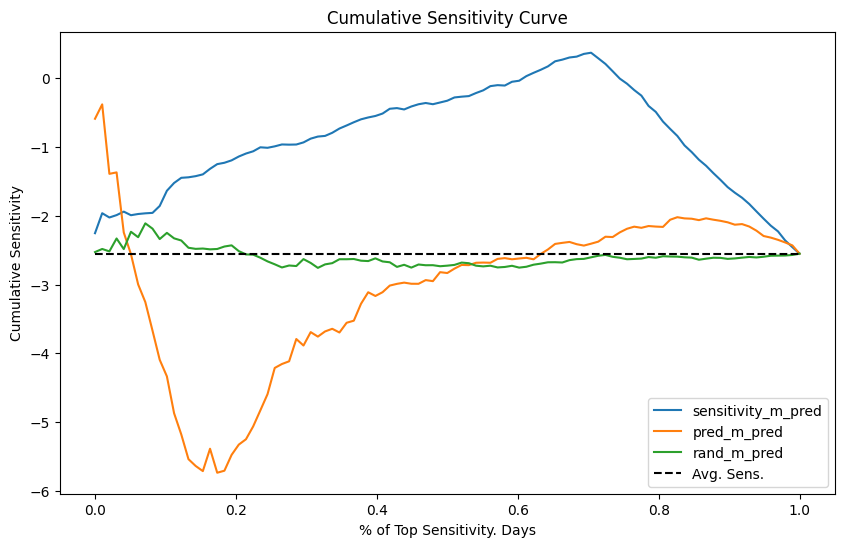

In [ ]:
plt.figure(figsize=(10,6))                                     # 그래프 크기 설정

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]: # 세 모델에 대해 반복
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100) # 각 모델의 누적 민감도 곡선 계산
    x = np.array(range(len(cumu_sens)))                        # x축을 위한 배열 생성. 배열 길이는 누적 민감도 배열의 길이와 같음
    plt.plot(x/x.max(), cumu_sens, label=m)                    # x축을 정규화하여 최댓값으로 나눔(0에서 1까지 범위)

# 전체 데이터셋에 대한 평균 민감도를 수평선으로 그림(평균 민감도=최종점 기준, 0%에서 100%까지)
plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")  # X축 레이블 설정
plt.ylabel("Cumulative Sensitivity")      # Y축 레이블 설정
plt.title("Cumulative Sensitivity Curve") # 그래프 제목 설정
plt.legend();                             # 범례 설정

* 일반론
  * **X축:** 샘플의 수를 비율로 정규화하여 표현, (예) 0.4라고 표시되어 있으면, 샘플의 40%를 처리하고 있다는 의미
  * **Y축:** 해당 샘플에서 기대되는 민감도, (예) 어떤 곡선이 40%에서 -1 가진다면, 상위 40%의 단위에서 민감도가 -1이라는 것을 의미
  * **이상적인 곡선**은 Y축의 높은 위치에서 시작하여 매우 천천히 평균 민감도로 내려가는 형태, 이는 높은 비율의 샘플을 처리하면서도 평균 이상의 민감도를 유지할 수 있음을 나타냄

* 우리 사안의 경우,
  * 어떤 모델도 이상적인 민감도 곡선에 근접하지 못함
  * **랜덤 모델**
    * 평균 민감도 주변에서 오르내리며, 평균에서 크게 벗어나지 않음
    * 모델이 평균과 다른 민감도를 가진 그룹을 찾지 못했다는 것을 의미
  * **M2**
    * 곡선이 평균 민감도 아래에서 시작하여 민감도가 역순으로 정렬되는 것처럼 보임
    * 그리고 약 50%의 샘플에서 매우 빠르게 평균 민감도로 수렴
  * **M1**
    * 누적 민감도가 평균에서 멀어지다가 샘플의 약 75% 지점에서 거의 0에 가까운 상당히 좋은 민감도를 유지하며 안정화
    * 아마도 모델이 매우 낮은 민감도(즉, 가격에 대한 민감도가 높은 날)를 식별할 수 있기 때문에 발생? 이러한 날에는 가격 올리면 안 될 것
    * 그러나 샘플의 대부분(약 75%)에서 낮은 가격 민감도를 유지하는 것으로 보임

* 이상에서 본 것처럼, 모델 평가 측면에서 **'누적 민감도 곡선'**은 **'밴드별 민감도'**라는 단순한 개념보다 유용
  * 그러나 여전히 모든 세부사항을 완전히 이해하기에는 복잡하고, 개선 여지

## Cumulative Gain Curve

* **누적 이득 곡선(Cumulative Gain Curve)**
  * 누적 민감도 개념을 발전시키는 매우 간단하면서도 강력한 아이디어는 **누적 민감도에 샘플 크기 비율을 곱하는 것**
    * (예) 누적 민감도가 40%에서 -0.5라면, 그 지점에서 -0.2 = (-0.5) * 0.4)
    *
$
\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}
$

  * 그 후에 이 값을 **랜덤 모델**에 의해 생성된 이론적 곡선과 비교
    * **랜덤 모델**에서는 누적 민감도의 모든 지점이 **ATE**이고, 위과 같이 곱한 곡선은 **0에서 ATE까지 직선**을 이룰 것인바, 이를 벤치마크 삼는 것
    * 모든 모델에서 곡선은 같은 지점에서 시작하고 끝나겠지만, 더 나은 민감도 정렬을 보이는 모델일수록 곡선이 0과 1 사이에서 랜덤 선과 많이 벗어날 것
    * 예컨대, 아래 이미지에서 M2이 ATE 도달 전에 M1보다 랜덤 선에서 더 많이 벗어나기 때문에 더 낫다고 평가할 수 있음
  * **인과 추론 모델의 ROC 커브**로 볼수 있음

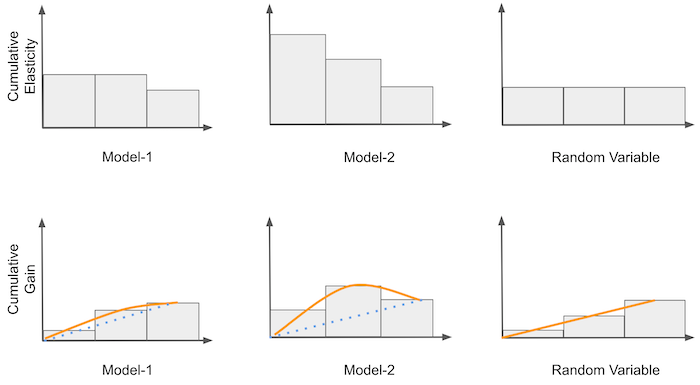

* **ROC (Receiver Operating Characteristic) Curve** 설명

  * 이진 분류기의 결정 임곗값 변경하면서 성능 평가
  * 개요
    * X축 위양성 비율[False Positive Rate; FPR, 1-특이도(specificity)]
    * Y축 참양성 비율[True Positive Rate; TPR, 민감도(sensitivity)=재현율(recall)]
    * 두 클래스 잘 분류할 수록 ROC 커브가 좌상단에 가까워짐(완전한 랜덤 분류기는 대각선)
  * ROC 커브 아래 면적이 AUC(Area Under the Curve)
    * AUC=0.5이면 무작위 추측과 같은 성능
    * AUC가 1에 가까울수록 모델 성능이 좋고, 0.5보다 작으면 무작위 추측보다 나쁜 성능
  * 참고
    * ★ 공돌이의 수학정리노트 https://angeloyeo.github.io/2020/08/05/ROC.html
    * 노마드분석가, "ROC 곡선 아주 쉽게 이해하기", 의미를 이해하는 통계학과 데이터 분석 https://diseny.tistory.com/entry/ROC-%EA%B3%A1%EC%84%A0-%EC%95%84%EC%A3%BC-%EC%89%BD%EA%B2%8C-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0
    * 조슈아박, "분류 모델 성능 평가지표" https://data-panic.tistory.com/18
    * SH의 학습노트, "헷갈리는 통계기본 - 정확도, 정밀도, 재현율, 특이도, G-mean, F1 measure, ROC curve&AUC, Gain Chart & Lift curve 정리" https://todayisbetterthanyesterday.tistory.com/5

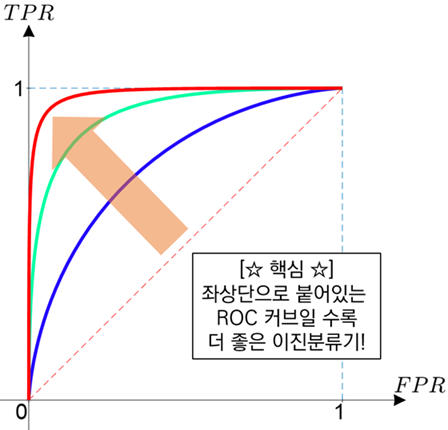

In [ ]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows]) # 민감도에 정규화 요소 'rows/size'(데이터셋 전체 크기에 대한 비율) 곱함

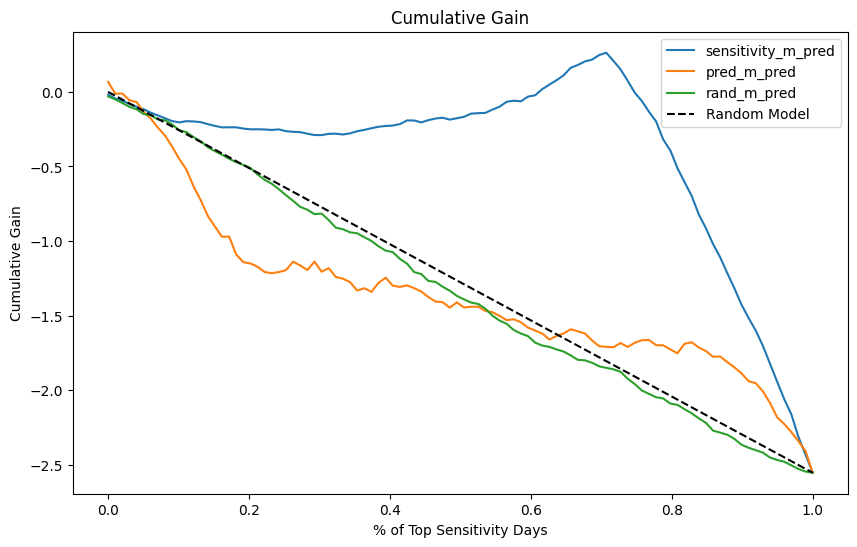

In [ ]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100) # min_periods=50으로 줄여서 누적 이익 곡선의 초기 부분 변화를 더 빨리 관찰
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black") # 대각선을 비교 기준으로 설정(무작위 기준선)
                                                                                                                           # X축/Y축상 시작점, 끝점은 리스트로 표현
plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend();

* M1이 다른 두 모델보다 훨씬 나음
* 실제 랜덤 모델(rand_m_pred)이 이론적 랜덤 모델("Random Model")을 매우 밀접하게 따르는 것에도 주목
  * 차이가 발생하는 것은 무작위 노이즈 때문일 것
* 이제 측정값에 대한 신뢰구간(분산)을 포함시켜야

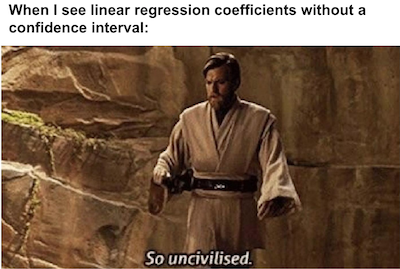

## Taking Variance Into Account

* 선형회귀 모델의 계수 $\beta_1$에 대한 **신뢰구간(confidence interval; CI)**
  * 표본 크기에 관계없이 모분산 $\theta^2$ 알 때: **정규분포** 사용
    * $\hat{\beta}\_1 \pm z\_{\alpha/2} \times \text{SE}(\hat{\beta}\_1)$

  * 표본 크기가 작거나, 모분산 $\theta^2$ 모르는 경우: **자유도 n-2인 t 분포** 사용
    * $\hat{\beta}\_1 \pm t_{\alpha/2, n-2} \times \text{SE}(\hat{\beta}_1)$

    * 추정되는 두 개의 파라미터(절편과 기울기) 때문에 자유도에서 2 빼준다
    * n>30이면 t분포가 정규분포에 근사하나, 표본 크기가 작은 경우에는 t-분포를 사용하는 것이 더 정확, t-분포는 표본 크기가 작을 때(자유도 작을 때) 더 두터운 꼬리를 가지는데, 이는 더 넓은(보수적인) 신뢰구간을 의미하고 추정치의 불확실성(변동성)이 더 크다는 점을 반영
  * **회귀계수 $\beta_1$의 표준오차(Standard Error)**
    * $
s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}
$
    * $\hat{\\epsilon}\_i$​는 i번째 관측값에 대한 잔차(실제 관측값 $y\_i$​와 회귀선에 의해 예측된 값 $\\hat{y}\_i$​의 차이)
    * 분자에 나오는 잔차의 제곱합 $\sum\_i\\hat{\\epsilon}\_i^2$은 모델의 적합도에 대한 정보(잔차가 작을수록 모델이 데이터를 잘 설명함을 의미)
    * n은 관측값 총 수, $t\_i$​는 독립변수의 관측값, $\bar{t}$는 독립변수의 평균값
    * 분모의 $(n-2)\sum\_i(t\_i-\\bar t)^2$는 조정된 총 변동량으로 독립변수의 분산에 자유도 조정을 적용한 값



In [ ]:
def sensitivity_ci(df, y, t, z=1.96):                                # z=1.96 (95% 신뢰수준)
    n = df.shape[0]                                                  # 데이터 프레임의 행 수(데이터의 개수)를 n으로 정의
    t_bar = df[t].mean()                                             # 독립변수(t)의 평균값 계산
    beta1 = sensitivity(df, y, t)                                    # sensitivity 함수를 사용하여 beta1 계수 추정 [10] 코드 참조
    beta0 = df[y].mean() - beta1 * t_bar                             # beta0 계수 계산
    e = df[y] - (beta0 + beta1*df[t])                                # 잔차 계산
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))  # 표준오차 계산: 잔차 제곱합을 n-2로 나눈 값에 독립변수의 변량 합으로 나눔
    return np.array([beta1 - z*se, beta1 + z*se])

* 회귀계수 계산&nbsp;&nbsp;&nbsp;$\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}$
* 절편 계산&nbsp;&nbsp;&nbsp;$\beta_0 = \overline{y} - \beta_1 \overline{t}$
* 잔차 계산&nbsp;&nbsp;&nbsp;$e = y - (\beta_0 + \beta_1 t)$
* 표준오차 계산&nbsp;&nbsp;&nbsp;$\text{SE}(\hat{\beta}_1) = \sqrt{\frac{1}{n-2} \sum_{i=1}^n \left(e_i\right)^2 \bigg/ \sum_{i=1}^n \left(t_i - \bar{t}\right)^2}$

In [ ]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]                                                               # 데이터셋의 전체 행 수 가져오기
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)  # 'prediction' 열에 따라 데이터셋 내림차순 정렬하고 인덱스를 재설정
    n_rows = list(range(min_periods, size, size // steps)) + [size]                       # min_periods부터 시작해 size까지 size // steps 간격으로 숫자를 생성, 마지막에 '[size]' 추가

    # 'sensitivity' 함수 호출하는 대신 'sensitivity_ci' 함수 호출로 변경하여, 각 점에서의 민감도 대신 95% 신뢰구간 계산
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])    # 각 구간별 최상위 데이터 바탕으로 신뢰구간 계산

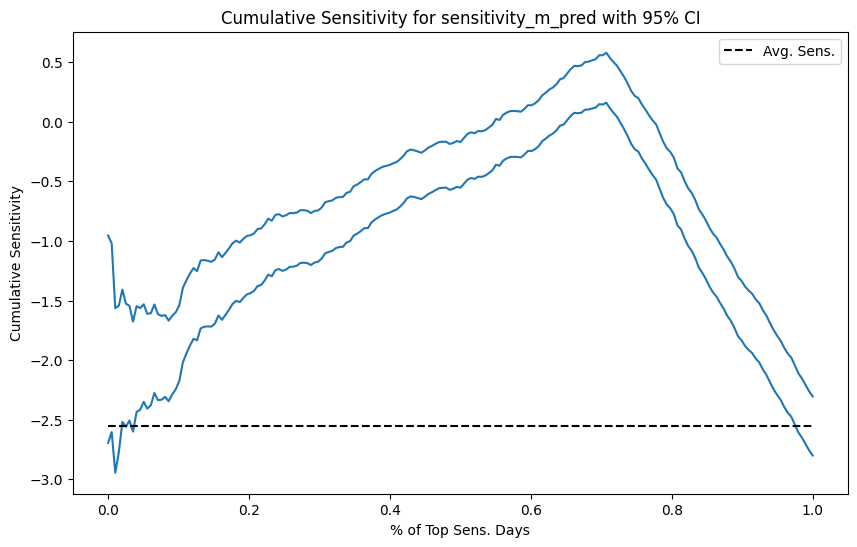

In [ ]:
plt.figure(figsize=(10,6))                                     # 그래프 크기 설정

# 'cumulative_sensitivity_curve_ci' 함수 사용하여 'sensitivity_m_pred' 모델의 누적 민감도 곡선과 95% 신뢰구간 계산
cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200) # min_periods 50으로 줄이고, steps 200으로 증가
                                                                                                                                   # 누적 민감도 곡선의 세부 변화 더 자세히 관찰할 수 있음
x = np.array(range(len(cumu_gain_ci)))                        # x축을 위한 배열 생성. 배열 길이는 누적 민감도 배열의 길이와 같음
plt.plot(x/x.max(), cumu_gain_ci, color="C0")                 # x축 정규화, 신뢰구간 상하한 곡선 그림

# 전체 데이터셋에 대한 평균 민감도를 수평선으로 그림(모델 성능의 기준선)
plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend();

* 데이터 누적될수록 표본 크기가 커져 신뢰구간 작아짐

* 누적 이득 곡선도 신뢰구간 구할 수
  * 마찬가지로 sensitivity 함수를 sensitivity_ci 함수로 대체하기만 하면 됨

In [ ]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

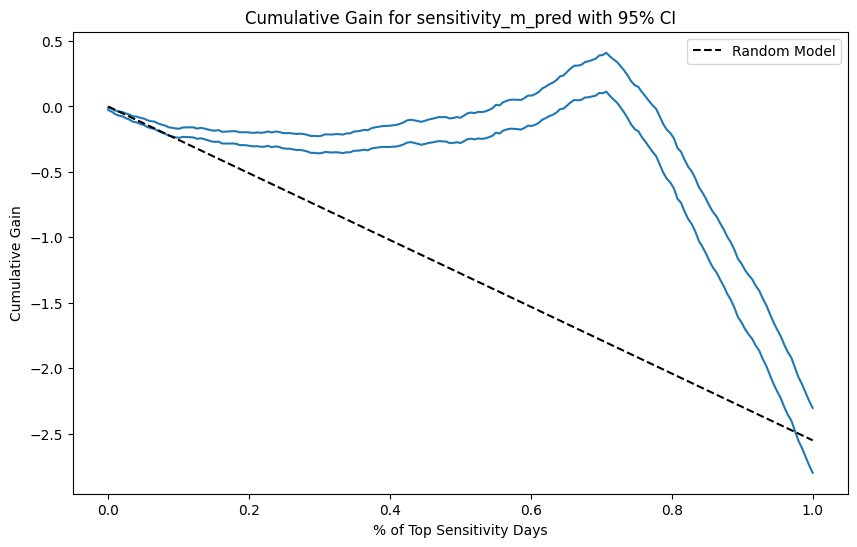

In [ ]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();

* 곡선 시작 부분에서 표본 크기 작음에도 신뢰구간이 작게 시작
  * 정규화 계수(k/n)가 ATE 매개변수와 신뢰구간 함께 축소시키기 때문
  * 이는 모든 모델에 동일하게 적용되므로 문제 없음

## Key Ideas

* 인과추론이 머신러닝만큼 대중화되기 위해서는 모델 평가 방법론이 필요
  * 이 장에서 제안한 방법론 통해 개체 민감도 볼 수 없어도 각 모델이 서로 다른 민감도를 가진 그룹들을 얼마나 잘 식별해내는지 확인할 수 있음
  * 그러나 아직은 일종의 길거리 과학(science from the streets) 수준
* 무작위 데이터에 크게 의존함
  * 비무작위 데이터로 훈련 후 평가는 처치가 무작위화된 표본에서 함
  * 훈련-테스트 패러다임에 가깝게
  * 무작위 데이터가 없다면 이 장에서 사용한 간단한 공식들이 작동하지 않을 것[교란변수(confounding value)의 존재로 인해 단순 선형회귀에서는 생략된 변수 편향(omitted variable bias; OVB) 발생]
  * 다음 장에서는 무작위가 아닌 데이터 문제 다룸

## References


  * Pierre Gutierrez, Jean-Yves Gérardy, **"Causal Inference and Uplift Modelling: A Review of the Literature"**, Proceedings of The 3rd International Conference on Predictive Applications and APIs, PMLR 67:1-13, 2017 https://proceedings.mlr.press/v67/gutierrez17a.html (Qini 곡선에서 아이디어 가져와 연속적 처치 사례에 일반화)

    **[Abstract]** 업리프트 모델링은 어떤 행동이나 처치가 고객 결과에 미치는 점진적인 영향을 모델링하는 데 사용되는 일련의 기술을 말한다. 따라서 업리프트 모델링은 인과추론 문제이자 머신러닝 문제이기도 하다. 업리프트에 관한 문헌은 크게 두 모델 접근법, 클래스 변환 접근법, 업리프트를 직접 모델링하는 접근법의 세 가지 주요 접근법으로 나뉜다. 안타깝게도 인과추론과 표기법에 대한 공통된 프레임워크가 없는 상황에서 이 세 가지 방법을 평가하는 것은 매우 어려울 수 있다. 이 글에서는 Rubin(1974)의 인과추론 모델과 현대의 '계량경제학' 표기법을 사용하여 세 가지 접근법을 명확하게 비교하고 그중 하나를 일반화한다. 우리가 알기로는 이 글이 업리프트 문헌에 대한 통합적인 검토를 제공하는 최초의 논문이다. 또한, 이 논문은 인과 효과 추정자에 대한 평균제곱오차(MSE) 공식을 최소화하는 것이 관측되지 않은 치료 효과를 수정된 목표변수로 대체할 때 MSE를 최소화하는 것과 동일하다는 것을 보여줌으로써 기여하고 있다. 마지막으로, 이 논문이 의학, 사회학, 경제학 등 다른 분야뿐만 아니라 비즈니스 맥락에서 인과추론 문제에 머신러닝 기법을 적용하는 데 관심이 있는 연구자들에게 도움이 되기를 바란다.
  * Leo Breiman, **"Statistical Modeling: The Two Cultures (with comments and a rejoinder by the author)"**, Statist. Sci. 16 (3) 199 - 231, August 2001. https://doi.org/10.1214/ss/1009213726

      **[Abstract]** 데이터에서 결론을 도출하기 위해 통계 모델링을 사용하는 두 가지 문화가 있다. 하나는 데이터가 주어진 확률적 데이터 모델에 의해 생성되었다고 가정한다. 다른 하나는 알고리듬 모델을 사용하며 데이터 메커니즘을 알 수 없는 것으로 간주한다. 통계학계는 데이터 모델을 거의 독점적으로 사용하려고 노력해 왔다. 이러한 고집은 관련 없는 이론과 의심스러운 결론으로 이어졌고, 통계학자들이 흥미로운 최신 문제를 연구하는 데 방해가 되었다. 알고리듬 모델링은 통계학 외 분야의 이론과 실무 양면에서 빠르게 발전해 왔다. 복잡한 대규모 데이터 집합은 물론 소규모 데이터 집합의 데이터 모델링에 대한 보다 정확하고 유익한 대안으로 사용될 수 있다. 데이터를 사용하여 문제를 해결하는 것이 우리의 목표라면, 데이터 모델에 대한 배타적인 의존에서 벗어나 보다 다양한 도구를 도입해야 한다.